In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.nn.utils.rnn import pad_sequence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import re
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

In [0]:
# Setting up data paths
train_background_path = "drive/My Drive/Speaker_identity/trn_background.csv"
train_black_list_path = "drive/My Drive/Speaker_identity/trn_blacklist.csv"
test_data_path = "drive/My Drive/Speaker_identity/tst_evaluation.csv"
test_keys_path = "drive/My Drive/Speaker_identity/tst_evaluation_keys.csv"

In [0]:
# Building header
h1 = [i for i in range(601)]
h2 = [i for i in range(601)]
h3 = [i for i in range(601)]


In [0]:
df_background = pd.read_csv(train_background_path, skiprows=[0], names= h1)
df_black = pd.read_csv(train_black_list_path, skiprows=[0] , names = h2) 
df_test = pd.read_csv(test_data_path ,skiprows=[0] ,names  =h3)  # test data
df_keys = pd.read_csv(test_keys_path)   # test_data answers

In [249]:
print(df_keys)
# the keys match each speaker in the test data to background or black_listed speaker ID 

                id bl_matching         set
0      wvcp_071162  background  evaluation
1      qijd_669595  background  evaluation
2      dsng_127334  background    progress
3      gmaf_850693  background    progress
4      qnae_473935        grpp    progress
...            ...         ...         ...
16012  veeo_223163  background  evaluation
16013  tehn_720156        swhh  evaluation
16014  tfvi_964632  background  evaluation
16015  mfba_088192  background  evaluation
16016  lqdb_095778  background  evaluation

[16017 rows x 3 columns]


In [0]:
df_test = df_test[df_keys["set"] == "progress"]


In [0]:
df_keys = df_keys[df_keys["set"] == "progress"]

In [252]:
# Note that df_back_ground contains ivectors for non black listed people
# And df_black, the black_listed people
# Lets have a look at the data set
print(df_background.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30952 entries, 0 to 30951
Columns: 601 entries, 0 to 600
dtypes: float64(600), object(1)
memory usage: 141.9+ MB
None


In [0]:
# The data contains the speaker ID(0) and 600 dimentional ivector(1 - 600) corrosponding to them

# Now lets plot and see using PCA reduction how the normal and balcklisted ivectors lie
pca = PCA(n_components=2)

In [0]:
# Dropping ID and just keeping the ivectors
normal_ivectors = df_background.drop(0 , axis = 1).values
black_ivectors = df_black.drop(0 , axis = 1).values
test_ivectors = df_test.drop(0 , axis = 1).values

In [0]:
# Now combining these vectors together so that we can get the PCA
sep_index = len(normal_ivectors) -1
ivectors = np.concatenate( (normal_ivectors , black_ivectors) , axis = 0)

In [0]:
# These are 2 dimentional representation
principalComponents = pca.fit_transform(ivectors)

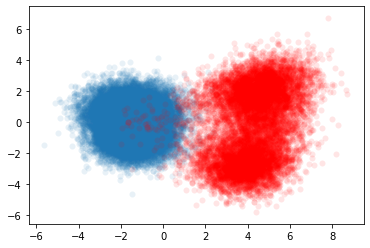

In [257]:
# Lets plot em
plt.scatter(principalComponents[:sep_index, 0] ,principalComponents[:sep_index, 1], linewidths = .01 , alpha = .1 )
plt.scatter(principalComponents[sep_index:, 0] ,principalComponents[sep_index:, 1], linewidths = .01 , c = "r" , alpha = .1)
# Blue for normal_speakers and red for the black_listed ones

As we can see the PCA gives a nice separation between the two classes, so the classes are already well seperated in the ivectors

In [0]:
ivector_labels = np.zeros(len(ivectors))
ivector_labels[sep_index:] += 1

In [0]:
test_labels = []
for catagory in df_keys["bl_matching"]:
    if(catagory == "background"):
        test_labels.append(0)
    else:
        test_labels.append(1)


In [0]:
class average_classifier():
    def __init__(self, class1_points , class2_points):
        self.class1_average =  np.average(class1_points , axis = 0)
        self.class2_average = np.average(class2_points , axis = 0)
    def closest_vector(self, v1 , v2, v3):
        d1 = np.linalg.norm(v1- v2)
        d2 = np.linalg.norm(v1 - v3)
        if(d1 > d2):
            return 1
        else:
            return 0
    def classifier(self,test_vectors):
        result = []
        for v in test_vectors:
            result.append(self.closest_vector(v , self.class1_average,self.class2_average))
        return result

    def miss_classifications(self,test_result,test_labels):
        sm = 0
        for i,j in zip(test_result,test_labels):
            if(i != j):
                sm += 1
        return sm

class KNN:
    def __init__(self ,trained_points ,train_classes ,N =3 ,):
        self.trained_points = trained_points
        self.train_classes = train_classes
        self.sep_index = sep_index # all index from [0:sep_index -1] are class 0 and rest 1
        self.classifier = KNeighborsClassifier(n_neighbors=N, n_jobs =-1)
        self.classifier.fit(self.trained_points, train_classes)

    def classify(self, test_points):
        return self.classifier.predict(test_points)

    def miss_classifications(self,test_result,test_labels):
        sm = 0
        for i,j in zip(test_result,test_labels):
            if(i != j):
                sm += 1
        return sm




In [0]:
avg_classifier =  average_classifier(normal_ivectors , black_ivectors)
result1 = avg_classifier.classifier(test_ivectors)

In [430]:
print(avg_classifier.miss_classifications(result1,test_labels))

1841


In [0]:
classifier = KNN(trained_points = ivectors ,train_classes= ivector_labels, N = 3)
result2 = classifier.classify(test_ivectors)


In [173]:
classifier.miss_classifications(result2,test_labels)

2772

With the orignal data the average classifier gives 2880 miss classification
And the KNN gives 2772. Which is bad as the paper reduced this count to 428 !!!!

In [0]:
 # This function clubs the ivectors of same speakers together (to be applied to group by)
def extract_ivectors(df):
    return [ivector for ivector in df["ivector"] ]

# This function removes numbers from the ID so that we can group by IDs
def remove_nums(ID):
    ID = re.sub(r'[^a-zA-Z]','',ID) # remove numbers
    return ID

In [0]:
# Restructuring the data
normal_df = pd.DataFrame({"ID":df_background[0].values.tolist() , "ivector":normal_ivectors.tolist()})
black_df =  pd.DataFrame({"ID":df_black[0].values.tolist() , "ivector":black_ivectors.tolist()})
#test_df = pd.DataFrame({"ID":df_test[0].values.tolist() , "ivector":test_ivectors.tolist()})
normal_df["ID"] = normal_df["ID"].apply(remove_nums)
black_df["ID"] = black_df["ID"].apply(remove_nums)
#test_df["ID"] = test_df["ID"].apply(remove_nums)


In [0]:
black_df = black_df.groupby("ID").apply(extract_ivectors)
normal_df= normal_df.groupby("ID").apply(extract_ivectors)
#test_df = test_df.groupby("ID").apply(extract_ivectors)
del df_black
del df_background


In [0]:
black_df = black_df.values
normal_df = normal_df.values

So now we have extracted and grouped ivectors according to the ID of the people.

Note that every black_listed speaker has 3 ivectors, and every normal speaker has 4-5

In [0]:
# Lets make a scheme to create triplets
# We make 2 types of pairs
# One (normal , normal , black)
# two (black_si , balck_si , black_sj)  where si is speaker i
def get_random_utterance(data):
    L = len(data)
    # lets pick a random speaker
    speaker_id = np.random.randint(low = 0 , high = L -1)
    speaker = data[speaker_id]
    # Returning any random utterance of the speaker
    return random.choice(speaker)
    


def make_triplets_one(data_normal ,data_black , num_triplets , ivector_length):
    triplets = np.empty((num_triplets*3 ,ivector_length),dtype =np.float32)
    for i in range(num_triplets):
        triplets[i] = get_random_utterance(data_normal)
        triplets[i+num_triplets] = get_random_utterance(data_normal) 
        triplets[i+2*num_triplets] = get_random_utterance(data_black)
    return triplets



In [0]:
# Now lets make a batch_feeder function for the first task
def get_train_batch_one(data_normal , data_black,  batch_size ,  ivector_length = 600):
    batch = torch.tensor(make_triplets_one(data_normal, data_black , batch_size , ivector_length))
    return batch




***Lets start building the model***

In [0]:
class Model1(nn.Module):
    def __init__(self ,hidden_size, latent_space_dim , ivector_length = 600  ):
        super().__init__()
        self.hidden_size = hidden_size
        self.ivector_length = ivector_length
        self.latent_space_dim = latent_space_dim
        self.linear1 = nn.Linear(self.ivector_length , self.hidden_size)
        self.linear2 = nn.Linear(self.hidden_size , self.latent_space_dim)
       
        self.relu1 = nn.ReLU()
        self.sig = nn.Sigmoid()
    def forward(self , triplets):
        X = self.linear1(triplets)
        X = self.relu1(X)
        X = self.linear2(X)
        return self.sig(X)
    


In [0]:
crit = nn.PairwiseDistance(2)
def loss_one(model_out ,alpha ):
    epsilon = 1e-6
    batch_size , _ = model_out.size()
    index = batch_size//3
    dist_similar = crit(model_out[0:index, :] , model_out[index:2*index, :])
    dist_different = crit(model_out[0:index,:] , model_out[2*index:, :])
    dist_similar = -torch.log(-(dist_similar/alpha)+1+epsilon)
    dist_different = -torch.log(-((alpha-dist_different)/alpha)+1+epsilon)
    # compute loss
    loss = dist_similar + dist_different
    return loss.mean()

In [0]:
model1 = Model1(hidden_size = 1000 , latent_space_dim = 600)

In [0]:
learning_rate = .001
optimizer = torch.optim.Adam(list(model1.parameters()), learning_rate)

In [0]:
def train(model , epochs , batch_size):
    for _ in range(epochs):
        batch = get_train_batch_one(normal_df , black_df,  batch_size ,  ivector_length = 600)
        model_out = model(batch)
        loss = loss_one(model_out,1000)
        if(isinstance(loss , int)):
            continue
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(loss.item())
   # loss_arr.append(epoch_loss/inner_loop_size)

In [0]:
train(model1 ,200, 1024)

In [0]:
trained_ivectors = model1(torch.tensor(ivectors).float()).detach().numpy()
transformed_test_ivectors = model1(torch.tensor(test_ivectors).float()).detach().numpy()

In [0]:
principalComponents = pca.fit_transform(trained_ivectors)

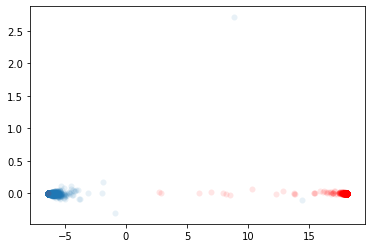

In [482]:
# Lets plot em
plt.scatter(principalComponents[:sep_index, 0] ,principalComponents[:sep_index, 1], linewidths = .01 , alpha = .1 )
plt.scatter(principalComponents[sep_index:, 0] ,principalComponents[sep_index:, 1], linewidths = .01 , c = "r" , alpha = .1)

# Blue for normal_speakers and red for the black_listed ones

As you can see, we have achieved better clusterring by training. Depending on the training and creation of dataset this will vary

In [0]:
# Now lets have alook at the results....
# Transforming the test matrix by the model..

In [0]:
transformed_normal_ivectors = trained_ivectors[:sep_index]
transformed_black_ivectors = trained_ivectors[sep_index:] 

In [0]:
avg_classifier =  average_classifier(transformed_normal_ivectors , transformed_black_ivectors)
result1 = avg_classifier.classifier(transformed_test_ivectors)

In [486]:
print(avg_classifier.miss_classifications(result1,test_labels))

1121


In [0]:
# Now for the KNN classifier
classifier = KNN(trained_points = trained_ivectors ,train_classes= ivector_labels, N = 3)
result2 = classifier.classify(transformed_test_ivectors)

In [488]:
classifier.miss_classifications(result2,test_labels)

1289

So by training with a triplet loss, We have improved the performance of both the classifiers